In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import islice
from scipy import stats

In [55]:
debugging = False
def y(n):
    return _y.loc[n,0]

def good_vs_bad(df):
    print(f"frame,n: {FRAME},{N}")
    #display(df.sort_values(by='|Vf|'))
    bins = list(range(0,30,3))
    #bins=None
    plt.rcParams['figure.figsize'] = [20, 5]
    (df.loc[df.right_direction,'|Vf|']*0.45849128846870446).hist(bins=bins)
    (df.loc[df.good,'|Vf|']*0.45849128846870446).hist(bins=bins)

def mutating_base_calcs(df, n):
    df['dx'] = df.x2 - df.x1 + 0.00001
    df['dy'] = (df.y2 - df.y1)/n
    df['Vf_slope'] = df.dy/df.dx
    df['|Vf|'] = np.sqrt(df.dx**2 + df.dy**2)

    df['right_direction'] = (df.y2>df.y1) & (abs(df.Vf_slope) > 3) # down and steep
    df['good'] = df['right_direction']

def analyze_lk_optical_flow_dfs(dfs):
    xs = []
    def analyze_df(df):
        nonlocal xs
        # absurd
        #df['good'] = df['good'] & (df['|Vf|'] > 2.5)
        df['good'] = df['good'] & (df['|Vf|'] < (30/.45))
        
        if sum(df['good']==True) == 0:
            xs += [np.nan, np.nan]
        else:
            with np.errstate(divide='ignore',invalid='ignore'):
                df.loc[df['good'],'z'] = stats.zscore(df.loc[df['good'],'|Vf|'])
            df.loc[df['good']==False,'z'] = 100.0
            df['good'] = df['good'] & (df['z'] < 1.7)

            if len(df) != 0:
                # filter out noisy "small" flow vectors
                Vf_max_good = df[df['good']==True]['|Vf|'].max()
                df['good'] = df['good'] & (df['|Vf|'] > Vf_max_good * 0.25)
            xs.append(df.loc[df['good'],'|Vf|'].mean())
            xs.append(df.loc[df['good'],'|Vf|'].std())
        xs.append(df['dy'].mean())
    overall = 0
    for n, df in enumerate(dfs):
        global N
        N = n + 1
        mutating_base_calcs(df,N)
        analyze_df(df)
            
        overall += df.loc[df['good'],'|Vf|'].mean()/len(dfs+1)
    
    stacked_df = pd.concat(dfs, ignore_index=True)
    analyze_df(stacked_df)
    overall += stacked_df.loc[df['good'],'|Vf|'].mean()/len(dfs+1)
    
    xs.append(overall)
    if debugging:
        
        for n, df in enumerate(dfs):
            N = n + 1
        
            good_vs_bad(df)
            plt.vlines(y(FRAME),0,10,colors='orange')
            plt.vlines(xs[n*2]*0.45849128846870446,0,10,colors='pink')
            plt.vlines(overall*0.45849128846870446,0,10,colors='red')
            
            plt.vlines(xs[10]*0.45849128846870446,0,12,colors='purple') #stacked
            plt.show()
        return overall
    return xs



method = analyze_lk_optical_flow_dfs

In [56]:
def frames(whichones):
    for frame in whichones:
        global FRAME
        FRAME = frame
        yield [pd.read_pickle(f'./1603934455/{frame}_{n}.pkl') for n in range(3)] 

In [ ]:
debugging = True

#158,  81, 189,  83,  80, 188,  82,  77, 190, 157
centa_loc = 190
N = 0
FRAME = 0
dbg_xs = []
dbg_frames = list(range(centa_loc*100, centa_loc*100+100, 1))
dbg_frames = list(range(0, 20400, 100))

for i, dfs in enumerate(frames(dbg_frames)):
    debugging = i % 10 == 0 # inspect every 10th
    dbg_xs.append(method(dfs))

# Big run

In [ ]:
assert False

In [57]:
debugging = False

xs = []
for dfs in frames(range(20400)):
    xs.append(method(dfs))      

/home/y2k/.local/share/virtualenvs/y2kspeed-NWwxFr2U/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/y2k/.local/share/virtualenvs/y2kspeed-NWwxFr2U/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/y2k/.local/share/virtualenvs/y2kspeed-NWwxFr2U/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/y2k/.local/share/virtualenvs/y2kspeed-NWwxFr2U/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/y2k/.local/share/virtualenvs/y2kspeed-NWwxFr2U/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/y2k/.local/share/virtualenvs/y2kspeed-N

In [182]:
_y = pd.read_csv('../../data/train.txt', header=None)
X = pd.DataFrame(xs)
X['y'] = _y[0]
X.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,20295.000000,20194.000000,20400.000000,20163.000000,20032.000000,20399.000000,19934.000000,19772.000000,20399.000000,20399.000000,20294.000000,20275.000000,20400.000000
mean,21.608633,5.367982,4.799234,21.437608,5.451011,2.844092,21.198285,5.564667,2.333646,3.325689,21.119492,5.348473,3.357223
std,15.472756,3.862062,9.669150,15.262463,4.104524,7.581492,14.846382,4.326651,6.865346,6.971654,14.947046,3.768748,7.012366
min,0.004153,0.002088,-116.187047,0.001527,0.000472,-126.458439,0.002043,0.000354,-99.169061,-113.938182,0.002558,0.001149,-114.883626
25%,8.155328,2.415671,-0.238537,8.179021,2.220518,-0.818561,8.329525,2.129330,-0.985925,-0.360364,8.154775,2.303320,-0.352002
50%,17.821728,4.484043,3.863911,17.761272,4.365603,2.245137,17.785306,4.384518,1.793814,2.673615,17.478245,4.549080,2.688383
75%,35.038089,7.558002,9.793322,34.740444,8.049747,6.362307,34.363407,8.349534,5.344351,6.730394,34.592763,8.034280,6.777629
max,65.475669,27.746017,83.617086,65.611763,34.490408,52.578316,66.602948,32.010217,48.778914,49.266747,61.936603,34.490408,49.815615


In [209]:
#for unaggregated 1,2,3 frames
#X.fillna(value=0, inplace=True)
X.fillna(method='pad', inplace=True)
X['X'] = (X[0] + X[2]/2 + X[4]/3 + 3*X[10])/6  #add "theoretical average"

X['X'] = (X[0] + X[10])/2  # add "theoretical average"
X.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,X,X_kf_,sq_err,X_kf
count,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,2.040000e+04,20400.000000
mean,21.641200,5.357514,4.799234,21.375072,5.440268,2.844011,21.119549,5.531517,2.333536,3.325557,21.101896,5.341885,3.357223,21.371548,17.110673,3.786554e+00,12.183182
std,15.521832,3.887483,9.669150,15.271821,4.154863,7.581315,14.911118,4.365130,6.865196,6.971509,14.958365,3.775437,7.012366,15.117274,11.079281,1.549477e+01,7.888696
min,0.004153,0.002088,-116.187047,0.001527,0.000472,-126.458439,0.002043,0.000354,-99.169061,-113.938182,0.002558,0.001149,-114.883626,0.004439,0.606191,2.207767e-11,0.431622
25%,8.154408,2.387577,-0.238537,8.116386,2.177804,-0.818544,8.243725,2.073851,-0.985770,-0.360238,8.151337,2.289064,-0.352002,8.252272,7.384423,1.957036e-01,5.257874
50%,17.845953,4.467752,3.863911,17.736967,4.345204,2.245015,17.582149,4.339522,1.793400,2.673602,17.452299,4.544122,2.688383,17.741874,14.824135,8.115465e-01,10.555116
75%,35.082254,7.538273,9.793322,34.658218,8.039996,6.361703,34.298546,8.301038,5.344049,6.730266,34.575544,8.024870,6.777629,34.752710,28.845647,2.210013e+00,20.538746
max,65.475669,27.746017,83.617086,65.611763,34.490408,52.578316,66.602948,32.010217,48.778914,49.266747,61.936603,34.490408,49.815615,60.417776,37.253990,1.640289e+02,26.525674


In [270]:
# tune a kalman filter
from pykalman import KalmanFilter
em_vars = [
     #'transition_covariance',
     'observation_covariance',
     'initial_state_mean', 'initial_state_covariance']

T = np.array([[.0015]]) # smaller is more resistance to acceleration

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_covariance=T)
#kf = kf.em(_y[0].values, n_iter=0, em_vars=em_vars)

In [278]:
# training_mean = _y[0].mean() # for full comparison, overly optimistic though
# print(training_mean,X['X_kf_'].mean(),X['X'].mean())
# print(training_mean/X['X_kf_'].mean())
# print(training_mean/X['X'].mean())

velocity_per_vf = .577

X['X_kf'] = kf.smooth(X['X'].values)[0] * velocity_per_vf
X['X_scaled'] = X['X'] * velocity_per_vf

In [279]:
X['sq_err'] = (X['X_kf'] - _y[0])**2
err = X['sq_err'].mean()
print(f"{err:0.1f}")

3.5


In [273]:
# base algorith 7.43
# *tweak Vf quality gates
# Overall 3.8
# Stacked 3.97
# Overall including stacked 3.6
# fix "overall" calc 3.5

In [274]:
# Areas of highest loss
df = X.copy()
df = df.groupby(np.arange(len(df.index)) // 100).mean()
df.sort_values(by='sq_err', ascending=False).head(10).index.values

array([ 81,  83,  82,  80,  84,  56,   0,  77,  11, 149])

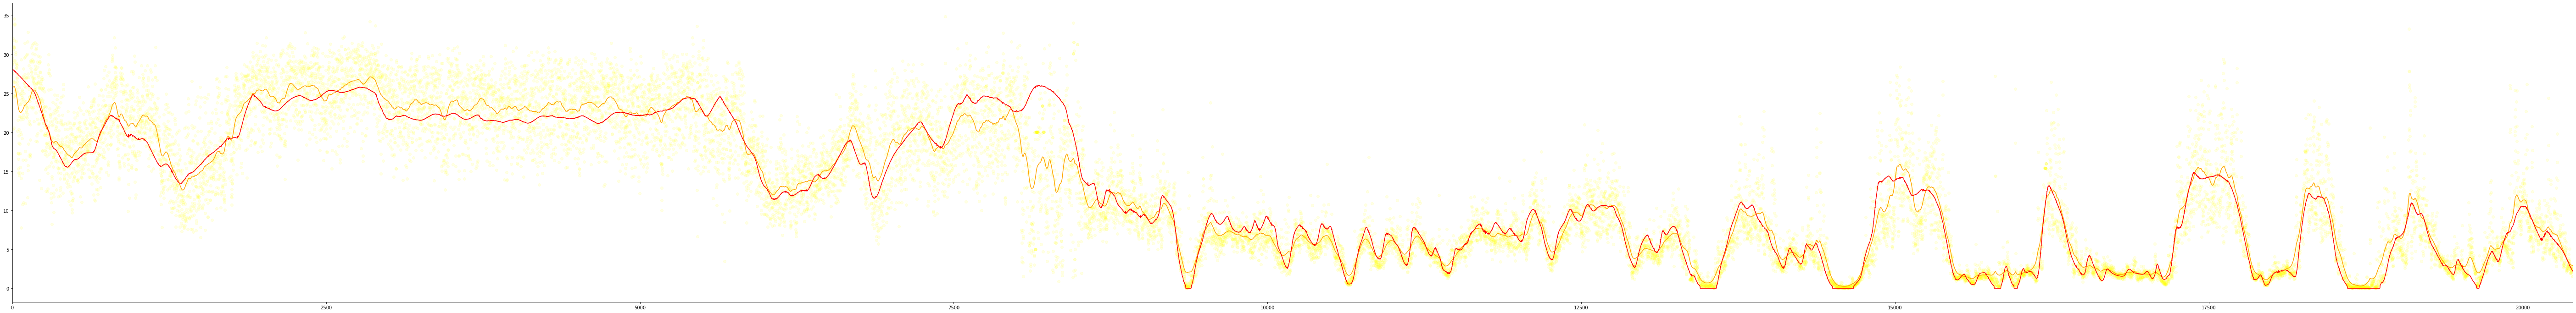

In [275]:
plt.rcParams['figure.figsize'] = [100, 12]
plt.gca().set_xlim((0,len(X)))
def plot_X(ix_mask, column, **kwargs):
    try:
        if ix_mask is None:
            df = X.loc[:,column]
        else:
            df = X.loc[ix_mask, column]
        plt.plot(df.index, df.values, **kwargs)
    except KeyError:
        print(f"Skipping {column}")
    
#plot_X(Xy2_test_ix, 'pred', marker='o', linewidth=0.0, color='green', alpha=.1)
#plot_Xy2(Xy2_train_ix, 'pred', marker='o', linewidth=0.0, color='purple', alpha=.1)
plot_X(None, 'X_scaled', marker='o', linewidth=0.0, color='yellow', alpha=.1)
plot_X(None, 'X_kf', marker='', linewidth=1.5, color='orange')
#plot_X(None, '1_thresh', marker='', linewidth=0.5, color='blue')
plot_X(None, 'y', marker='', linewidth=1.4, color='red')
#plot_X(Xy2_test_ix, 'pred_kf', marker='o', linewidth=0.0, color='green', alpha=.1)